# Model classes
Setting up a simulation in PorePy requires a certain knowledge of the code - both _what_ objects need to be defined and _how_ to define them. To simplify this task, PorePy exploits encapsulation through `Model` classes for some common problems. These contain methods for parameter specification, equation specification, discretization, assembly and solving of the (non)linear problem. The `Model`s provide an overview of the entire problem setup and may be tailored and extended according to the user's need by overwriting of the relevant methods. The class [AbstractModel](https://github.com/pmgbergen/porepy/blob/develop/src/porepy/models/abstract_model.py) is the common base class for all `Model`s, which in turn partly are built based on inheritance (e.g. `ContactMechanics(AbstractModel)` and `ContactMechanicsBiot(ContactMechanics)`.


# Incompressible flow
In this tutorial, we demonstrate the `Model` concept using the class [IncompressibleFlow](https://github.com/pmgbergen/porepy/blob/incompressible_flow_tutorial/src/porepy/models/incompressible_flow_model.py) as an example. The tutorial explores some of the central methods of the class and shows how adjustments may be made. 
To set out, we define the governing equations for mixed-dimensional incompressible flow 
$$\begin{align}\label{eq:mixed_dim_flow}
q_i + K/\mu \nabla p_i &= 0 \qquad &\texttt{in } \Omega_i,\\
 \nabla \cdot q_i - \sum_j \Xi_j^i \lambda_j  &= f \qquad &\texttt{in } \Omega_i,\\
\lambda_j + \kappa (\Pi_j^l p_{l} - \Pi_j^l \texttt{tr }p_{h}) &= 0 \qquad &\texttt{on } \Gamma_j, \\
q_i \cdot n &= \Xi_j^i \lambda_j \qquad &\texttt{on } \partial_j \Omega_i.
\end{align}$$
Refering to  [Keilegavlen et al.](https://link.springer.com/article/10.1007/s10596-020-10002-5) for detailed conceptual and notational descriptions, we here note that $\Omega$ and $\Gamma$ denote subdomains and interfaces, respectively, while $\partial_j \Omega_i$ is the internal boundary of $\Omega_i$ coinciding geometrically with $\Gamma_j$. $q$, $p$ and $\lambda$ are the unknown flux, pressure and interface flux, while $\Pi$ and $\Xi$ are projections, respectively from subdomains to interfaces and from interfaces to subdomains.

Observe that all the modifications can be made in a single subclass. From the pedagogical point of view, the inheritance concept is invoked for each change to expose adjustments in an incremental manner.

## Minimal setup
As always, we start by importing some modules:

In [1]:
import porepy as pp
import numpy as np
import inspect

We can now instantiate an object with default values for all parameters:

In [2]:
default_model = pp.IncompressibleFlow()

Let's have a look at some of the important methods. Parameter assignment is handled by looping over all subdomains and interfaces:

In [3]:
print(inspect.getsource(default_model._set_parameters))

    def _set_parameters(self) -> None:
        """Set default (unitary/zero) parameters for the flow problem.

        The parameters fields of the data dictionaries are updated for all
        subdomains and edges (of codimension 1).
        """
        for g, d in self.gb:
            bc = self._bc_type(g)
            bc_values = self._bc_values(g)

            source_values = self._source(g)

            specific_volume = self._specific_volume(g)

            kappa = self._permeability(g) / self._viscosity(g)
            diffusivity = pp.SecondOrderTensor(
                kappa * specific_volume * np.ones(g.num_cells)
            )

            gravity = self._vector_source(g)

            pp.initialize_data(
                g,
                d,
                self.parameter_key,
                {
                    "bc": bc,
                    "bc_values": bc_values,
                    "source": source_values,
                    "second_order_tensor": diffusivity,
           

The method calls other model methods to obtain values for most of the parameters. As we will see below, this allows us to e.g. change the boundary conditions without redefining the whole `_set_parameters` method.
Another essential method is the one which defines the equations through by a combination of discretization and variable objects based on autmatic differentiation (AD). The method first defines the objects which take care of assembly and global degree-of-freedoms. Then, we define lists of subdomains and interfaces, which are used to produce AD variables, discretizations, projection operators etc. Finally, the equations are written out very much like in the equation system above:

In [4]:
print(inspect.getsource(default_model._assign_discretizations))

    def _assign_discretizations(self) -> None:
        """Define equations through discretizations.

        Assigns a Laplace/Darcy problem discretized using Mpfa on all subdomains with
        Neumann conditions on all internal boundaries. On edges of co-dimension one,
        interface fluxes are related to higher- and lower-dimensional pressures using
        the RobinCoupling.

        Gravity is included, but may be set to 0 through assignment of the vector_source
        parameter.
        """
        gb = self.gb
        dof_manager = pp.DofManager(gb)
        self.dof_manager = dof_manager
        self.assembler = pp.Assembler(self.gb, self.dof_manager)
        self._eq_manager = pp.ad.EquationManager(gb, dof_manager)

        grid_list = [g for g, _ in gb.nodes()]
        self.grid_list = grid_list
        if len(self.gb.grids_of_dimension(self.gb.dim_max())) != 1:
            raise NotImplementedError("This will require further work")

        edge_list = [e for e, d in gb.e

There are several other methods which may be of interest to a user. To understand the flow of a simulation, we should understand that we will run the simulation by using the PorePy method `run_stationary_problem`. This method calls the `Model` methods 
 
 - prepare_simulation
 - before_newton_loop
 - after_newton_convergence
 - after_newton_loop
 - after_simulation
 The somewhat confusing name "newton" is due to legacy reasons from an implementation aimed at non-linear problems solved with a Newton scheme. In our context, we should read them as "before solving the equation system" etc.
 ## Minimal adjustments
 Before running the simulation, we will visit the `create_grid` method. While a default grid is provided in [AbstractModel](https://github.com/pmgbergen/porepy/blob/develop/src/porepy/models/abstract_model.py), the user will usually want to specify the mixed-dimensional grid to be used. This will serve as our first example of how to make a modification to the [IncompressibleFlow](https://github.com/pmgbergen/porepy/blob/incompressible_flow_tutorial/src/porepy/models/incompressible_flow_model.py) model:

In [5]:
class ChangedGrid(pp.IncompressibleFlow):
    """An Incompressible flow class with non-default grid bucket.
    """
    def create_grid(self) -> None:
        """Create the grid bucket.

        A unit square grid with one vertical fracture extending from y =0.2 to
        y=0.5 is assigned.

        The method assigns the following attributes to self:
            gb (pp.GridBucket): The produced grid bucket.
            box (dict): The bounding box of the domain, defined through minimum and
                maximum values in each dimension.
        """
        # Use default mesh size if none are provided in the parameters passed to the class
        # on initialization
        mesh_args = self.params.get("mesh_args", {"mesh_size_frac": .1})
        endp = np.array([.2, .5])
        self.gb, self.box = pp.grid_buckets_2d.single_vertical(mesh_args, endp, simplex=True)
        

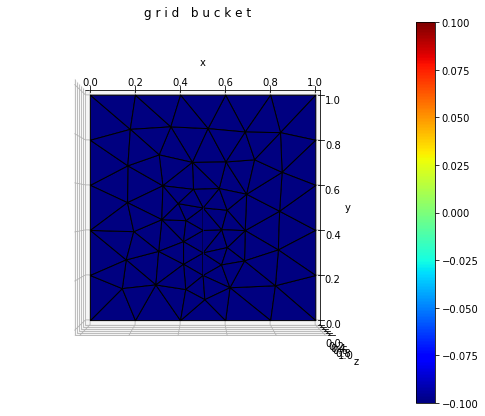

In [6]:
params = {}
model_changed_grid = ChangedGrid(params)
pp.run_stationary_model(model_changed_grid, params)
pp.plot_grid(model_changed_grid.gb, model_changed_grid.variable, figsize=[10,7])

Due to the default parameters (notably Dirichlet boundary conditions of value 0), the solution is homogeneous (or simply "really boring", if you prefer). We can make it somewhat more interesting by assigning a non-zero source term in our second adjustment. Note that we can base this next class on `ChangedGrid`, thereby using its `create_grid` method.

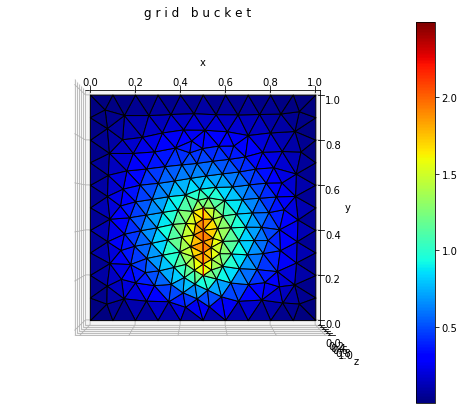

In [7]:
class UnitaryFractureSource(ChangedGrid):
    """An IncompressibleFlow model with modified grid and
    unitary source term in the fracture."""
    
    def _source(self, g: pp.Grid) -> np.ndarray:
        if g.dim == self.gb.dim_max():
            val = np.zeros(g.num_cells)
        else:
            val = np.ones(g.num_cells)
        return val

params.update({"mesh_args": {"mesh_size_frac": 0.05}})
model_source = UnitaryFractureSource(params)
pp.run_stationary_model(model_source, params)
pp.plot_grid(model_source.gb, model_source.variable, figsize=[10,7])

Note that in addition to producing a non-zero pressure solution, we also obtained a finer grid by passing meshing arguments in `params`. We can also investigate the value of the interface fluxes:

In [8]:
inds = model_source.dof_manager.dof_var(var=[model_source.mortar_variable])
vals = model_source.dof_manager.assemble_variable(variables = [model_source.mortar_variable])
interface_flux = vals[inds]
print(interface_flux)

[-0.59068028 -0.47969844 -0.45057056 -0.4500899  -0.47227967 -0.55919814
 -0.58835115 -0.47911445 -0.45293844 -0.45012337 -0.46935454 -0.55760107]


Recalling that the interface flux is defined from matrix to fracture, the negative signs make sense given the source being assigned in the fracture only. 
## Other extensions
Using the same approach, other methods can be overwritten to change the problem in other ways. Obvious examples are the methods called by `_set_parameters`. 3d problems are readily defined through constructing a 3d `GridBucket` in `create_grid`. We will show two final examples, one for slightly more involved dynamics and one indicating how to avoid code duplication when adjusting the models.
### Gravity
Suppose we want to solve the above problem with an hydrostatic gradient in the y direction. This requires modification of the boundary condition values and the addition of a gravity (or more generally, "vector source") term:

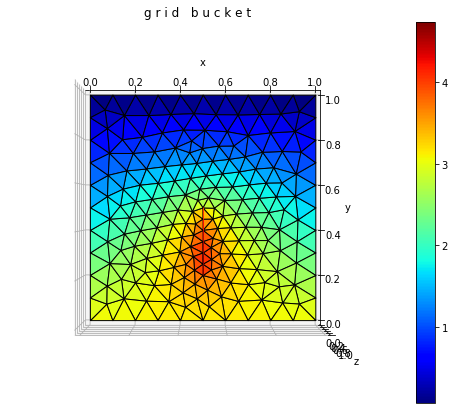

In [9]:
density = 1 / np.pi

class Gravity(UnitaryFractureSource):
    """An IncompressibleFlow model with gravity effects.
    """
    def _vector_source(self, g: pp.Grid) -> np.ndarray:
        source_values = np.zeros((self.gb.dim_max(), g.num_cells))
        # Assign value in the y component
        source_values[-1] = - density * pp.GRAVITY_ACCELERATION
        return source_values
    
    def _bc_values(self, g: pp.Grid) -> np.ndarray:
        bf, *_ = self._domain_boundary_sides(g)
        bc_values = np.zeros(g.num_faces)

        # Assign value in the y component
        bc_values[bf] = density * pp.GRAVITY_ACCELERATION * (1 - g.face_centers[1, bf])
        return bc_values
    
model_gravity = Gravity(params)
pp.run_stationary_model(model_gravity, params)
pp.plot_grid(model_gravity.gb, model_gravity.variable, figsize=[10,7])

All fluxes, including interface fluxes, are the same as in the previous problem:

In [10]:
inds = model_gravity.dof_manager.dof_var(var=[model_gravity.mortar_variable])
vals = model_gravity.dof_manager.assemble_variable(variables = [model_gravity.mortar_variable])
interface_flux_grav = vals[inds]
assert np.all(np.isclose(interface_flux_grav, interface_flux))

### Python `super` method
A useful tip for exploiting the fact that the `Model` is a Python `Class` is the use of the `super` method. As our final example, say we want to use the source method of the parent class and then add something. We achieve this by inheriting from `UnitaryFractureSource` and calling its `_source` method:

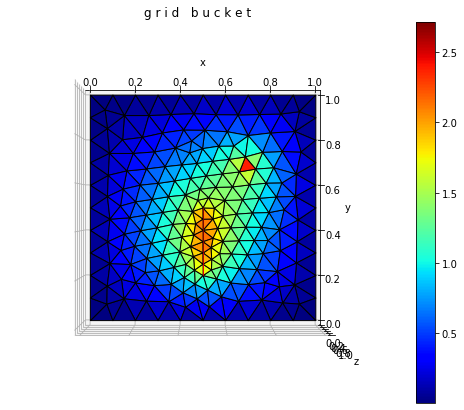

In [11]:
class FractureAndMatrixSource(UnitaryFractureSource):
    """An IncompressibleFlow model with modified grid and
    source term in both matrix and fracture."""
    
    def _source(self, g: pp.Grid) -> np.ndarray:
        """Return cell-wise source values.
        
        First call parent class method, then add value in matrix.
        
        Parameters:
            g (Grid): The grid for which the source values are computed.
            
        Returns:
            np.ndarray (g.num_cells): The cell-wise values.
        """
        # Gives 0 in matrix and 1 in fractures.
        val = super()._source(g)
        if g.dim == self.gb.dim_max():
            cell = g.closest_cell(np.reshape([0.7, 0.7, 0], (3,1)))
            val[cell] = 3
        return val
model = FractureAndMatrixSource(params)
pp.run_stationary_model(model, params)
pp.plot_grid(model.gb, model.variable, figsize=[10,7])